In [1]:
print("--- Importing Libraries ---")
from IPython.display import display, Image
import os
import time
import random
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow # Specific to Colab
import locale
import shutil # Added for file operations during evaluation
import sys # For checking if in Colab
import warnings

--- Importing Libraries ---


In [2]:
print("\n--- Mounting Google Drive ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Google Colab environment. Skipping Drive mount.")
    # If not in Colab, you might need to adjust paths below manually
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    sys.exit("Could not mount Google Drive. Please check permissions.")


--- Mounting Google Drive ---
Mounted at /content/drive
Google Drive mounted successfully.


In [3]:
print("\n--- Preparing Data Paths ---")
# IMPORTANT: Set home path to the PARENT directory containing your 'Dataset' folder in Google Drive
# Example: If your dataset is at '/content/drive/MyDrive/AI_Dentistry/Dataset',
# then HOME should be '/content/drive/MyDrive/AI_Dentistry'
HOME = '/content/drive/MyDrive/Dataset'
dest_folder=f'{HOME}'
data_yaml_path = f"{dest_folder}/data.yaml"
if not os.path.exists(dest_folder):
  print(f"ERROR: Dataset folder not found at {dest_folder}. Please check the HOME path.")
  sys.exit(f"Dataset folder not found at {dest_folder}.") # Stop if dataset not found
else:
  print(f"Dataset folder found at: {dest_folder}")

# Verify data.yaml exists
if not os.path.exists(data_yaml_path):
    print(f"ERROR: data.yaml not found at {data_yaml_path}. Training cannot proceed.")
    sys.exit(f"data.yaml not found at {data_yaml_path}.")
else:
     print(f"Data config file found at: {data_yaml_path}")



--- Preparing Data Paths ---
Dataset folder found at: /content/drive/MyDrive/Dataset
Data config file found at: /content/drive/MyDrive/Dataset/data.yaml


In [4]:
def load_filenames(folder):
  """Loads all file names from a folder in a list, ignoring subdirectories."""
  filenames = []
  try:
      for filename in os.listdir(folder):
        # Make sure to only load files, not directories if any exist
        if os.path.isfile(os.path.join(folder, filename)):
            filenames.append(filename)
  except FileNotFoundError:
      print(f"Warning: Directory not found: {folder}")
  return filenames

In [5]:
print("\n--- Counting Ground Truth Instances ---")
def count_instances(label_files, base_label_path, instance_list):
  """Reads label files and counts instances per class."""
  gt_labels_read = []
  for label_file in label_files:
    file_path = os.path.join(base_label_path, label_file)
    try:
      with open(file_path) as f:
        for line in f:
            parts = line.split()
            if parts: # Ensure line is not empty
                gt_labels_read.append(parts[0])
    except FileNotFoundError:
      print(f"Warning: Label file not found: {file_path}")
    except Exception as e:
      print(f"Error reading {label_file}: {e}")
  # Count occurrences
  for class_idx in range(len(instance_list)):
      instance_list[class_idx] = gt_labels_read.count(str(class_idx))
  return gt_labels_read # Return the flat list of labels found

# Initialize counts
instances_train=[0]*10
instances_valid=[0]*10
instances_test=[0]*10
total_train_imgs = 0
total_valid_imgs = 0
total_test_imgs = 0

# Process Train
print('Train data statistics:')
train_label_dir = f'{dest_folder}/train/labels'
train_label_files = load_filenames(train_label_dir)
total_train_imgs = len(load_filenames(f'{dest_folder}/train/images')) # Count images separately
gt_labels_train = count_instances(train_label_files, train_label_dir, instances_train)
for i in range(10): print(f'Instances of class {i}', instances_train[i])
print('Total instances in train data:', sum(instances_train))
print('Total images in train data:', total_train_imgs)

# Process Valid
print('\nValid data statistics:')
valid_label_dir = f'{dest_folder}/valid/labels'
valid_label_files = load_filenames(valid_label_dir)
total_valid_imgs = len(load_filenames(f'{dest_folder}/valid/images'))
gt_labels_valid = count_instances(valid_label_files, valid_label_dir, instances_valid)
for i in range(10): print(f'Instances of class {i}', instances_valid[i])
print('Total instances in valid data:', sum(instances_valid))
print('Total images in valid data:', total_valid_imgs)

# Process Test
print('\nTest data statistics:')
test_label_dir = f'{dest_folder}/test/labels'
test_label_files = load_filenames(test_label_dir)
total_test_imgs = len(load_filenames(f'{dest_folder}/test/images'))
gt_labels_test = count_instances(test_label_files, test_label_dir, instances_test)
for i in range(10): print(f'Instances of class {i}', instances_test[i])
print('Total instances in test data:', sum(instances_test))
print('Total images in test data:', total_test_imgs)

# Total Stats
print('\nTotal statistics')
for i in range(10): print(f'Instances of class {i}', instances_train[i]+instances_valid[i]+instances_test[i])
print('Total instances in total data:', sum(instances_train)+sum(instances_valid)+sum(instances_test))
print('Total images in total data:', total_train_imgs + total_valid_imgs + total_test_imgs)



--- Counting Ground Truth Instances ---
Train data statistics:
Instances of class 0 492
Instances of class 1 231
Instances of class 2 54
Instances of class 3 66
Instances of class 4 290
Instances of class 5 42
Instances of class 6 104
Instances of class 7 99
Instances of class 8 344
Instances of class 9 11
Total instances in train data: 1733
Total images in train data: 498

Valid data statistics:
Instances of class 0 51
Instances of class 1 7
Instances of class 2 6
Instances of class 3 5
Instances of class 4 27
Instances of class 5 5
Instances of class 6 9
Instances of class 7 12
Instances of class 8 42
Instances of class 9 2
Total instances in valid data: 166
Total images in valid data: 62

Test data statistics:
Instances of class 0 39
Instances of class 1 17
Instances of class 2 3
Instances of class 3 1
Instances of class 4 36
Instances of class 5 6
Instances of class 6 9
Instances of class 7 8
Instances of class 8 43
Instances of class 9 2
Total instances in test data: 164
Total im

In [6]:
print("\n--- Installing Ultralytics YOLOv8 ---")
# Using -q for quieter installation
!pip install --upgrade ultralytics -q

print("\n--- Importing YOLO and Checking Version ---")
try:
    import ultralytics
    from ultralytics import YOLO
    ultralytics.checks()
except ImportError:
    print("ERROR: Failed to import ultralytics. Installation might have failed.")
    sys.exit("Ultralytics import failed.")
except Exception as e:
    print(f"Error during Ultralytics check: {e}")
    sys.exit("Ultralytics check failed.")

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.1/112.6 GB disk)


In [7]:
print("\n--- Setting Training Configuration ---")
# List of models and epochs options (can be used to parameterize training)
models=['yolov8n.pt','yolov8s.pt','yolov8m.pt','yolov8l.pt','yolov8x.pt']
epochs_options=[50,100,150,200,250,300,350,400,450,500]

# --- Training Configuration ---
model_nr = 0       # Index for 'models' list (0 = yolov8n.pt)
image_size = 1408  # <<< CONSISTENT image size for train/val/predict
batch_size = 8    # START SMALLER! (e.g., 8 or 4 for T4 GPU with imgsz=1408) Adjust if OOM.
train_epochs = 50  # Number of epochs for this training run
if 0 <= model_nr < len(models):
    base_model_name = models[model_nr]
else:
    print(f"ERROR: Invalid model_nr index {model_nr}. Using default yolov8n.pt")
    base_model_name = 'yolov8n.pt'
    model_nr = 0 # Reset index

print(f"Selected base model: {base_model_name}")
print(f"Target image size: {image_size}")
print(f"Batch size: {batch_size} (Adjust if OOM errors occur)")
print(f"Epochs to train: {train_epochs}")


--- Setting Training Configuration ---
Selected base model: yolov8n.pt
Target image size: 1408
Batch size: 8 (Adjust if OOM errors occur)
Epochs to train: 50


In [8]:
print("\n--- Initializing Model Training ---")
# NOTE: This cell STARTS training from the selected base model (e.g., yolov8n.pt).
# It does NOT resume from a previous run unless you change the YOLO() line.

# Loading the selected BASE model (e.g., 'yolov8n.pt')
print(f"Loading base model: {base_model_name}...")
try:
    model_train = YOLO(base_model_name)
except Exception as e:
    print(f"ERROR: Failed to load base model {base_model_name}: {e}")
    sys.exit("Model loading failed.")

# Define experiment name based on configuration
experiment_name = f"{os.path.splitext(base_model_name)[0]}_epochs{train_epochs}_imgsz{image_size}_batch{batch_size}"

# Training the model
print(f"Starting training for {train_epochs} epochs...")
print(f"Configuration: Image Size={image_size}, Batch Size={batch_size}")
print(f"Results will be saved under: {HOME}/runs/detect/{experiment_name}")

t1=time.time() # returns time in seconds
try:
    # Start Training - Monitor GPU memory in Colab (Runtime -> View resources)
    model_train.train(
        data=data_yaml_path,
        epochs=train_epochs,         # Use the variable defined above
        imgsz=image_size,            # Use the consistent image size
        batch=batch_size,            # Use the potentially adjusted batch size
        device=0,                    # Use GPU 0
        cache=True,                  # Cache images in RAM if possible
        workers=2,                   # Use 2 workers for data loading (typical for Colab)
        fliplr=0.0,                  # Horizontal flips disabled
        mosaic=0.0,                  # Mosaic augmentation disabled (consider enabling -> mosaic=1.0 for small datasets)
        project=f"{HOME}/runs/detect", # Base directory for saving runs
        name=experiment_name         # Experiment name
    )
    t2=time.time()
    elapsed_time=round(t2-t1,2)
    print(f"\n--- Training finished successfully in {elapsed_time} seconds. ---")

    # --- Get the actual path where results were saved ---
    model_path = model_train.trainer.save_dir # This gets the exact path YOLO used
    print(f"Model and results saved to: {model_path}")
    # ----------------------------------------------------

    # Saving model info and timing info to a file within the run directory
    try:
        with open(f'{model_path}/training_summary.txt','w') as f:
            f.write(f'Base Model Used: {base_model_name}\n')
            f.write(f'Epochs Trained This Run: {train_epochs}\n')
            f.write(f'Image Size (imgsz): {image_size}\n')
            f.write(f'Batch Size: {batch_size}\n')
            # Corrected: Use model_train.info()
            model_info_str = str(model_train.info()) # Get model info as string
            f.write(f'Model Info: {model_info_str}\n') # Use str() for safety
            f.write(f'Training Wall time: {elapsed_time} sec\n')
            f.write(f'Results directory: {model_path}\n')
            f.write(f'{"*"*100}\n')
        print(f"Training summary saved to {model_path}/training_summary.txt")
    except Exception as e:
        print(f"Warning: Error writing training summary file: {e}")

except Exception as e:
    # Catch potential training errors (like OOM)
    print(f"\n--- ERROR DURING TRAINING ---")
    print(f"{e}")
    print("Training stopped. Check configuration (especially batch size) and GPU memory.")
    # Define model_path as None if training failed before it was set
    if 'model_train' in locals() and hasattr(model_train, 'trainer') and hasattr(model_train.trainer, 'save_dir'):
         model_path = model_train.trainer.save_dir # Try to get path even on failure
         print(f"Partial results might be found at: {model_path}")
    else:
         model_path = None
         print("Could not determine save directory.")
    # Optional: decide whether to stop the script or try to continue
    # sys.exit("Training failed.") # Uncomment to stop script on training error


--- Initializing Model Training ---
Loading base model: yolov8n.pt...


100%|██████████| 6.25M/6.25M [00:00<00:00, 104MB/s]


Starting training for 50 epochs...
Configuration: Image Size=1408, Batch Size=8
Results will be saved under: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch8
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Dataset/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=1408, save=True, save_period=-1, cache=True, device=0, workers=2, project=/content/drive/MyDrive/Dataset/runs/detect, name=yolov8n_epochs50_imgsz1408_batch82, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1,

100%|██████████| 755k/755k [00:00<00:00, 19.6MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Dataset/train/labels.cache... 498 images, 105 backgrounds, 0 corrupt: 100%|██████████| 498/498 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.5GB RAM): 100%|██████████| 498/498 [00:54<00:00,  9.12it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Dataset/valid/labels.cache... 62 images, 18 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.2GB RAM): 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


Plotting labels to /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1408 train, 1408 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       4.9G      2.133      6.884      2.097          4       1408: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all         62        166       0.98      0.054      0.206       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.91G      1.675      4.889      1.652         10       1408: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all         62        166      0.519      0.355      0.373      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.91G       1.63      4.152      1.599         21       1408: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all         62        166      0.674      0.492      0.527      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.93G      1.588      3.748      1.545          2       1408: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all         62        166      0.651      0.542      0.566      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.95G      1.558      3.581      1.521          5       1408: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all         62        166      0.586      0.587      0.578      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.96G       1.51      3.233       1.47         13       1408: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         62        166      0.715      0.526      0.593       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.98G      1.478      2.848      1.437          2       1408: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all         62        166       0.65       0.68      0.682      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         5G      1.455      2.613      1.447          4       1408: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all         62        166      0.697      0.669        0.7      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.01G      1.417      3.027      1.421          0       1408: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all         62        166      0.684      0.698      0.702      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.04G      1.403      2.255      1.404          3       1408: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all         62        166      0.721      0.659      0.654      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.04G      1.397       2.14      1.409          2       1408: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all         62        166      0.748      0.642      0.712      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.05G      1.371      1.948      1.407         10       1408: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         62        166      0.732      0.703      0.716      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.05G      1.351      1.929      1.373          5       1408: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all         62        166      0.774      0.741      0.735      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.05G      1.317      1.843      1.353          1       1408: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all         62        166      0.743      0.683      0.711      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.05G      1.317      1.647      1.353          7       1408: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all         62        166      0.847      0.649       0.72      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.05G      1.279      1.569      1.312          9       1408: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         62        166      0.711      0.686      0.694      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.05G      1.227      1.777      1.286          0       1408: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all         62        166      0.799      0.684      0.721      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.05G      1.253      1.473      1.304         12       1408: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all         62        166        0.7       0.75      0.709      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.05G      1.233      1.406      1.309          7       1408: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all         62        166      0.794      0.626      0.697      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.05G      1.202      1.349      1.262          7       1408: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         62        166      0.791      0.685      0.723      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.05G      1.207      1.307      1.257         14       1408: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all         62        166      0.768      0.669      0.713      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.05G      1.159      1.241      1.236          1       1408: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all         62        166      0.713      0.708      0.697      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.05G      1.153      1.229      1.253         10       1408: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         62        166      0.734      0.645      0.695      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.05G      1.145      1.179      1.216          6       1408: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         62        166      0.847      0.545      0.709      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.05G      1.104      1.149      1.207          8       1408: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all         62        166      0.701      0.777      0.758      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.05G       1.09      1.121      1.192         12       1408: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all         62        166      0.771      0.664      0.707      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.05G      1.061      1.094      1.183         19       1408: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all         62        166      0.744      0.667      0.672      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.05G       1.09      1.073      1.193          5       1408: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         62        166       0.77      0.638      0.692      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.05G      1.053      1.012      1.159          8       1408: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all         62        166      0.759      0.613      0.722      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.05G      1.026     0.9794      1.156          3       1408: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         62        166       0.82      0.602      0.721       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.05G      1.025     0.9645      1.145          7       1408: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all         62        166      0.783      0.667       0.71      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.05G     0.9966      0.959      1.134          1       1408: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all         62        166      0.827      0.679      0.707      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.07G     0.9746     0.9208       1.13          5       1408: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         62        166      0.807      0.643      0.728      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.08G     0.9604     0.8975      1.129          4       1408: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         62        166      0.713      0.685      0.747      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.09G     0.9461     0.9077      1.107          1       1408: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all         62        166       0.82      0.622      0.751      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       5.1G     0.9379     0.8622      1.101          1       1408: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all         62        166      0.831      0.652      0.764      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.1G     0.9005     0.8375      1.084         11       1408: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all         62        166      0.789      0.617      0.689      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       5.1G     0.9031      0.945      1.051          0       1408: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         62        166      0.812       0.65      0.766      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       5.1G     0.8953     0.8266      1.086         24       1408: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all         62        166       0.81      0.662       0.73      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.12G     0.8739     0.8075      1.056          5       1408: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all         62        166      0.831      0.683      0.784      0.458


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.12G     0.8575     0.7772      1.055          4       1408: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all         62        166      0.835      0.629      0.778      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.12G     0.8425     0.7682       1.06          7       1408: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         62        166       0.79      0.694      0.756      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.12G     0.8584     0.7686      1.055          5       1408: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         62        166      0.768      0.689      0.776      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.12G     0.8282     0.7533      1.047          3       1408: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all         62        166      0.829      0.636      0.764      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.12G     0.8314     0.7458      1.036          2       1408: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         62        166       0.86      0.634      0.773      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.12G     0.7915     0.7397      1.034         10       1408: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all         62        166      0.823      0.635      0.768      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.12G     0.7905     0.7247      1.017         14       1408: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all         62        166      0.857      0.619       0.77      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.12G     0.7692     0.7246      1.014          4       1408: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         62        166      0.835      0.668      0.786      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.12G     0.7675     0.7047      1.017         14       1408: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all         62        166      0.803      0.678      0.779       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.12G     0.7549     0.7015      1.015          2       1408: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all         62        166      0.857      0.645      0.781      0.436



50 epochs completed in 0.453 hours.
Optimizer stripped from /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


                   all         62        166      0.835      0.629      0.778      0.462
                     0         18         51      0.823       0.49      0.684      0.306
                     1          6          7      0.272      0.143      0.186      0.136
                     2          6          6          1       0.74      0.995      0.656
                     3          5          5      0.619        0.8      0.791      0.571
                     4         22         27      0.926      0.924      0.971      0.681
                     5          5          5      0.895        0.8      0.938      0.449
                     6          8          9          1      0.622      0.849      0.454
                     7         12         12      0.907      0.815      0.852      0.576
                     8         25         42      0.909       0.95      0.977      0.671
                     9          2          2          1          0      0.538      0.122
Speed: 0.8ms preproce

In [9]:
class_name=['Broken_Root','PCT','Free_R_Max','Free_L_Max','Not_Free_Max','Not_Free_Center_Max','Free_R_Mand','Free_L_Mand','Not_Free_Mand','Not_Free_Center_Mand']

# Diagnosing the issues from class labels
def diagnosis(all_detected_classes):
  # Input: A list of detected class names (strings) for a single image.
  # Output: A list of diagnostic strings.
  diagnosis_report=[]

  # --- Count Specific Findings ---
  total_broken_roots=all_detected_classes.count('Broken_Root')
  if total_broken_roots==0:
    diagnosis_report.append('No broken root detected.')
  elif total_broken_roots==1:
    diagnosis_report.append('A single broken root detected.')
  else:
    diagnosis_report.append(f'{total_broken_roots} broken roots detected.')

  total_PCT=all_detected_classes.count('PCT')
  if total_PCT==0:
    diagnosis_report.append('No periodontally compromised tooth detected.')
  elif total_PCT==1:
    diagnosis_report.append('A single periodontally compromised tooth detected.')
  else:
    diagnosis_report.append(f'{total_PCT} periodontally compromised teeth detected.')

  # --- Determine Kennedy Classification (Maxilla) ---
  max_findings = [cls for cls in all_detected_classes if 'Max' in cls]
  kennedy_max = "Maxillary Arch: Fully dentate or classification criteria not met."
  if max_findings: # Only classify if maxillary gaps are found
    has_free_r_max = 'Free_R_Max' in max_findings
    has_free_l_max = 'Free_L_Max' in max_findings
    has_not_free_max = 'Not_Free_Max' in max_findings
    has_not_free_center_max = 'Not_Free_Center_Max' in max_findings
    count_not_free_max = max_findings.count('Not_Free_Max')

    # Apply Kennedy Rules (Posterior-most dictates primary class)
    if has_not_free_center_max: # Class IV takes precedence if present
        kennedy_max = 'Maxillary Kennedy classification: Class IV (Anterior edentulous area crossing midline)'
    elif has_free_r_max and has_free_l_max: # Class I
        kennedy_max = 'Maxillary Kennedy classification: Class I (Bilateral posterior edentulous areas)'
    elif has_free_r_max or has_free_l_max: # Class II
        side = "right" if has_free_r_max else "left"
        kennedy_max = f'Maxillary Kennedy classification: Class II (Unilateral posterior edentulous area - {side})'
    elif has_not_free_max: # Class III
        plural = "s" if count_not_free_max > 1 else ""
        kennedy_max = f'Maxillary Kennedy classification: Class III ({count_not_free_max} bounded edentulous area{plural})'
    # TODO: Add logic for modifications if needed (based on other detected gaps)

  diagnosis_report.append(kennedy_max)

  # --- Determine Kennedy Classification (Mandible) ---
  mand_findings = [cls for cls in all_detected_classes if 'Mand' in cls]
  kennedy_mand = "Mandibular Arch: Fully dentate or classification criteria not met."
  if mand_findings: # Only classify if mandibular gaps are found
    has_free_r_mand = 'Free_R_Mand' in mand_findings
    has_free_l_mand = 'Free_L_Mand' in mand_findings
    has_not_free_mand = 'Not_Free_Mand' in mand_findings
    has_not_free_center_mand = 'Not_Free_Center_Mand' in mand_findings
    count_not_free_mand = mand_findings.count('Not_Free_Mand')

    # Apply Kennedy Rules (Posterior-most dictates primary class)
    if has_not_free_center_mand: # Class IV takes precedence if present
        kennedy_mand = 'Mandibular Kennedy classification: Class IV (Anterior edentulous area crossing midline)'
    elif has_free_r_mand and has_free_l_mand: # Class I
        kennedy_mand = 'Mandibular Kennedy classification: Class I (Bilateral posterior edentulous areas)'
    elif has_free_r_mand or has_free_l_mand: # Class II
        side = "right" if has_free_r_mand else "left"
        kennedy_mand = f'Mandibular Kennedy classification: Class II (Unilateral posterior edentulous area - {side})'
    elif has_not_free_mand: # Class III
        plural = "s" if count_not_free_mand > 1 else ""
        kennedy_mand = f'Mandibular Kennedy classification: Class III ({count_not_free_mand} bounded edentulous area{plural})'
    # TODO: Add logic for modifications if needed (based on other detected gaps)

  diagnosis_report.append(kennedy_mand)

  return diagnosis_report

In [10]:
# Check if training was successful and model_path is defined
if model_path and os.path.exists(f"{model_path}/weights/best.pt"):
    print(f"\n--- Running Prediction & Diagnosis Loop ---")
    print(f"Using trained model from: {model_path}")
    print(f"Saving detailed results to subfolders within: {model_path}")

    # Load the best model weights for prediction/evaluation
    try:
        model_predict = YOLO(f"{model_path}/weights/best.pt")
        print("Loaded best.pt weights for prediction.")
    except Exception as e:
        print(f"Warning: Could not load best.pt, trying last.pt. Error: {e}")
        try:
            model_predict = YOLO(f"{model_path}/weights/last.pt")
            print("Loaded last.pt weights for prediction.")
        except Exception as e_last:
             print(f"ERROR: Could not load best.pt or last.pt from {model_path}. Error: {e_last}")
             print("Skipping prediction loop.")
             model_predict = None # Ensure it's None if loading failed

    if model_predict:
        folder_names = ['train','valid','test']
        train_labels_pred = [] # Stores predicted labels for train set
        valid_labels_pred = [] # Stores predicted labels for valid set
        test_labels_pred = []  # Stores predicted labels for test set

        for fn in folder_names:
          print(f"\nProcessing {fn} set...")
          selected_folder = f'{dest_folder}/{fn}'
          image_folder = f'{selected_folder}/images'
          label_folder = f'{selected_folder}/labels'
          selected_filenames = load_filenames(image_folder)

          # Define path for the detailed output file inside the model's run directory
          output_txt_path = f'{model_path}/{fn}_detailed_predictions.txt'
          print(f"Saving detailed results to: {output_txt_path}")

          total_images=len(selected_filenames)
          if total_images == 0:
              print(f"Warning: No images found in {image_folder}")
              continue

          with open(output_txt_path,'w') as f:
            for img_no, img_filename in enumerate(selected_filenames):
              # Simple progress indicator
              if (img_no + 1) % 10 == 0 or (img_no + 1) == total_images:
                  print(f"  Processing {fn} image {img_no+1}/{total_images}: {img_filename}", end='\r')

              image_path = f'{image_folder}/{img_filename}'
              label_path = f'{label_folder}/{os.path.splitext(img_filename)[0]}.txt'

              if not os.path.exists(image_path):
                  f.write(f"Image no.: {img_no+1}\n")
                  f.write(f"Image title: {img_filename}\n\n" )
                  f.write(f"ERROR: Image file not found at {image_path}\n")
                  f.write(f'{100*"*"}\n\n')
                  continue

              # Making inference
              # Using rect=False as default, consistent with training flags
              try:
                  predicted = model_predict.predict(source=image_path,
                                                  imgsz=image_size,
                                                  rect=False, # Set to True if aspect ratios vary a lot AND trained with it
                                                  conf=0.25, # Standard confidence threshold
                                                  verbose=False) # Reduce console spam
              except Exception as predict_err:
                  print(f"\nError predicting image {img_filename}: {predict_err}")
                  f.write(f"Image no.: {img_no+1}\n")
                  f.write(f"Image title: {img_filename}\n\n" )
                  f.write(f"ERROR DURING PREDICTION: {predict_err}\n")
                  f.write(f'{100*"*"}\n\n')
                  continue # Skip to next image

              f.write(f'Image no.: {img_no+1}\n')
              f.write(f'Image title: {img_filename}\n\n' )
              f.write('Predicted Results:\n')

              # Check if prediction was successful and has results
              if not predicted or not predicted[0] or not hasattr(predicted[0], 'boxes'):
                   f.write('Total objects detected: 0 (Prediction failed or empty result)\n')
                   objects_predicted = 0
                   all_detected_classes = []
              else:
                  objects_predicted=len(predicted[0].boxes)
                  f.write(f'Total objects detected:{objects_predicted}\n')
                  f.write('Class     Class name               Bounding box coordinates (x_center,y_center,w,h) norm  Confidence level\n')
                  all_detected_classes=[]

                  for i in range(objects_predicted):
                    try:
                        # Access tensors directly for robustness
                        label = int(predicted[0].boxes.cls[i].item())
                        conf = predicted[0].boxes.conf[i].item()
                        box_coords = predicted[0].boxes.xywhn[i].tolist() # List [x, y, w, h]

                        # Saving labels based on the set being processed
                        if fn=='train':
                          train_labels_pred.append(label)
                        elif fn=='valid':
                          valid_labels_pred.append(label)
                        elif fn=='test':
                          test_labels_pred.append(label)

                        f.write(f'{label:2}        ')
                        all_detected_classes.append(f'{class_name[label]}')
                        f.write(f'{class_name[label]:<25}     ') # Left align class name
                        f.write(f'{box_coords[0]:.3f}, {box_coords[1]:.3f}, {box_coords[2]:.3f}, {box_coords[3]:.3f}            ')
                        f.write(f'{conf:.3f}\n')
                    except IndexError:
                         f.write(f'Error accessing prediction data for object {i}.\\n')
                    except Exception as e:
                         f.write(f'Unexpected error processing prediction {i}: {e}\\n')

              # --- Diagnosis ---
              results=diagnosis(all_detected_classes)
              f.write('\nDiagnosis:\n')
              [f.write(f'- {diag_item}\n') for diag_item in results]

              # --- Ground Truth ---
              f.write('\nGround Truth:\n')
              if os.path.exists(label_path):
                  with open(label_path) as f2:
                    f.write('Class     Class name               Bounding box coordinates (x_center,y_center,w,h) norm\n')
                    gt_count = 0
                    for line in f2:
                      try:
                        parts=line.strip().split()
                        if len(parts) == 5: # Check for correct format
                            gt_label = int(parts[0])
                            gt_x = float(parts[1])
                            gt_y = float(parts[2])
                            gt_w = float(parts[3])
                            gt_h = float(parts[4])
                            f.write(f'{gt_label:2}        ')
                            f.write(f'{class_name[gt_label]:<25}     ') # Left align
                            f.write(f'{gt_x:.3f}, {gt_y:.3f}, {gt_w:.3f}, {gt_h:.3f}\n')
                            gt_count += 1
                        else:
                             f.write(f'Skipping malformed ground truth line: {line.strip()}\n')
                      except (ValueError, IndexError, Exception) as e:
                          f.write(f'Error parsing ground truth line: {line.strip()} - {e}\n')
                    f.write(f'Total ground truth objects: {gt_count}\n')
              else:
                  f.write(f'Label file not found: {label_path}\n')

              f.write('\n')
              f.write(f'{100*"*"}\n\n')
          print(f"\nFinished processing {fn} set.") # Newline after loop finishes
else:
    print("\n--- Skipping Prediction & Diagnosis Loop ---")
    print("Reason: Training did not complete successfully or model path is not defined.")
    # Initialize prediction lists as empty if loop skipped
    train_labels_pred = []
    valid_labels_pred = []
    test_labels_pred = []



--- Running Prediction & Diagnosis Loop ---
Using trained model from: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82
Saving detailed results to subfolders within: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82
Loaded best.pt weights for prediction.

Processing train set...
Saving detailed results to: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/train_detailed_predictions.txt
  Processing train image 498/498: a926.png
Finished processing train set.

Processing valid set...
Saving detailed results to: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/valid_detailed_predictions.txt
  Processing valid image 62/62: a882.png
Finished processing valid set.

Processing test set...
Saving detailed results to: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/test_detailed_predictions.txt

Finished processing test set.


In [11]:
if model_path and os.path.exists(f"{model_path}/weights/best.pt"): # Only evaluate if training seemed successful
    print("\n--- Running Model Evaluation ---")

    # Define paths to dataset splits
    train_dir = f'{dest_folder}/train'
    valid_dir = f'{dest_folder}/valid'
    test_dir = f'{dest_folder}/test'
    temp_dir = f'{dest_folder}/temp_eval_dir' # Use a temporary directory name

    # Ensure temp directory doesn't exist initially
    if os.path.exists(temp_dir):
        try:
            shutil.rmtree(temp_dir)
        except OSError as e:
            print(f"Error removing old temp directory {temp_dir}: {e}")
            # Decide if this is critical enough to stop

    metrics_train = None
    metrics_test = None
    metrics_valid = None

    # --- Evaluate on TRAIN set ---
    print("\n--- Evaluating on TRAIN set ---")
    eval_success = False
    if os.path.exists(train_dir) and os.path.exists(valid_dir):
        try:
            # Move 'valid' out of the way, move 'train' to 'valid'
            shutil.move(valid_dir, temp_dir)
            shutil.move(train_dir, valid_dir)
            print(f"Moved {valid_dir} to {temp_dir}")
            print(f"Moved {train_dir} to {valid_dir}")
            # Evaluate (YOLO looks for 'valid' based on data.yaml)
            metrics_train = model_predict.val(data=data_yaml_path,
                                            batch=1, # Use batch=1 for evaluation consistency if needed
                                            imgsz=image_size,
                                            split='train', # Informative purpose
                                            save_json=True, # Save predictions for COCO eval
                                            project=model_path, # Save results within the training run folder
                                            name='eval_train_set', # Subfolder name
                                            verbose=False)
            eval_success = True
        except Exception as e:
            print(f"ERROR during TRAIN set evaluation: {e}")
        finally:
            # Move 'train' back from 'valid', move 'temp' back to 'valid'
            # Ensure paths exist before moving back
            if os.path.exists(valid_dir): # Check if 'train' is now at 'valid_dir'
                shutil.move(valid_dir, train_dir)
                print(f"Moved {valid_dir} back to {train_dir}")
            if os.path.exists(temp_dir): # Check if 'valid' is now at 'temp_dir'
                shutil.move(temp_dir, valid_dir)
                print(f"Moved {temp_dir} back to {valid_dir}")
            # Clean up temp dir if it somehow still exists and is empty
            if os.path.exists(temp_dir) and not os.listdir(temp_dir):
                 os.rmdir(temp_dir)

    else:
        print("Skipping TRAIN evaluation: train or valid directory missing.")

    # --- Evaluate on TEST set ---
    print("\n--- Evaluating on TEST set ---")
    eval_success = False
    if os.path.exists(test_dir) and os.path.exists(valid_dir):
        try:
            # Move 'valid' out of the way, move 'test' to 'valid'
            shutil.move(valid_dir, temp_dir)
            shutil.move(test_dir, valid_dir)
            print(f"Moved {valid_dir} to {temp_dir}")
            print(f"Moved {test_dir} to {valid_dir}")
            # Evaluate
            metrics_test = model_predict.val(data=data_yaml_path,
                                           batch=1,
                                           imgsz=image_size,
                                           split='test', # Informative
                                           save_json=True,
                                           project=model_path,
                                           name='eval_test_set',
                                           verbose=False)
            eval_success = True
        except Exception as e:
            print(f"ERROR during TEST set evaluation: {e}")
        finally:
            # Move 'test' back from 'valid', move 'temp' back to 'valid'
            if os.path.exists(valid_dir): # Check if 'test' is now at 'valid_dir'
                shutil.move(valid_dir, test_dir)
                print(f"Moved {valid_dir} back to {test_dir}")
            if os.path.exists(temp_dir): # Check if 'valid' is now at 'temp_dir'
                shutil.move(temp_dir, valid_dir)
                print(f"Moved {temp_dir} back to {valid_dir}")
            if os.path.exists(temp_dir) and not os.listdir(temp_dir):
                 os.rmdir(temp_dir)
    else:
        print("Skipping TEST evaluation: test or valid directory missing.")

    # --- Evaluate on VALID set ---
    print("\n--- Evaluating on VALID set ---")
    if os.path.exists(valid_dir): # Evaluate valid set (already in the correct place)
        try:
            metrics_valid = model_predict.val(data=data_yaml_path,
                                            batch=1,
                                            imgsz=image_size,
                                            split='val', # Informative
                                            save_json=True,
                                            project=model_path,
                                            name='eval_valid_set',
                                            verbose=False)
        except Exception as e:
            print(f"ERROR during VALID set evaluation: {e}")
    else:
        print("Skipping VALID evaluation: valid directory missing.")

    print("\n--- Evaluation Complete ---")
else:
    print("\n--- Skipping Model Evaluation ---")
    print("Reason: Training did not complete successfully or model path is not defined.")
    metrics_train = None
    metrics_test = None
    metrics_valid = None



--- Running Model Evaluation ---

--- Evaluating on TRAIN set ---
Moved /content/drive/MyDrive/Dataset/valid to /content/drive/MyDrive/Dataset/temp_eval_dir
Moved /content/drive/MyDrive/Dataset/train to /content/drive/MyDrive/Dataset/valid
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
ERROR during TRAIN set evaluation: val: Error loading data from /content/drive/MyDrive/Dataset/train/images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Moved /content/drive/MyDrive/Dataset/valid back to /content/drive/MyDrive/Dataset/train
Moved /content/drive/MyDrive/Dataset/temp_eval_dir back to /content/drive/MyDrive/Dataset/valid

--- Evaluating on TEST set ---
Moved /content/drive/MyDrive/Dataset/valid to /content/drive/MyDrive/Dataset/temp_eval_dir
Moved /content/drive/MyDrive/Dataset/test to /content/drive/MyDrive/Dataset/valid
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
ERROR during TEST set

val: Scanning /content/drive/MyDrive/Dataset/valid/labels.cache... 62 images, 18 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:05<00:00, 10.51it/s]


                   all         62        166      0.833       0.62      0.773       0.46
Speed: 2.4ms preprocess, 23.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/eval_valid_set/predictions.json...
Results saved to /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/eval_valid_set

--- Evaluation Complete ---


In [12]:
if model_path: # Only save summaries if training ran and produced a path
    print(f"\n--- Saving Evaluation Summaries ---")
    print(f"Summaries will be saved in: {model_path}")

    # Function to safely get metrics - handles None objects and missing attributes
    def get_metric(metrics_obj, metric_name, default_val=-1.0):
        try:
            if metrics_obj and hasattr(metrics_obj, 'box') and hasattr(metrics_obj.box, metric_name):
                return getattr(metrics_obj.box, metric_name)
            elif metrics_obj and hasattr(metrics_obj, metric_name): # Fallback for older versions?
                 return getattr(metrics_obj, metric_name)
        except Exception:
            pass # Ignore errors and return default
        return default_val

    # Function to safely get class results - handles None objects, missing methods/indices
    def get_class_ap_and_maps(metrics_obj, class_index, default_vals=(-1.0, -1.0, -1.0, -1.0)):
        """Returns P, R, mAP50, mAP50-95 for a given class index."""
        if not metrics_obj or not hasattr(metrics_obj, 'ap_per_class'):
            return default_vals
        try:
            # Find the actual index used by metrics (might not include all classes if no GT/preds)
            if hasattr(metrics_obj, 'ap_class_index') and class_index in metrics_obj.ap_class_index:
                internal_idx = metrics_obj.ap_class_index.index(class_index)

                p = metrics_obj.p[internal_idx] if hasattr(metrics_obj, 'p') and len(metrics_obj.p) > internal_idx else default_vals[0]
                r = metrics_obj.r[internal_idx] if hasattr(metrics_obj, 'r') and len(metrics_obj.r) > internal_idx else default_vals[1]
                ap50 = metrics_obj.ap50[internal_idx] if hasattr(metrics_obj, 'ap50') and len(metrics_obj.ap50) > internal_idx else default_vals[2]
                ap = metrics_obj.ap[internal_idx] if hasattr(metrics_obj, 'ap') and len(metrics_obj.ap) > internal_idx else default_vals[3]
                return p, r, ap50, ap
            else:
                # Class was not evaluated (no GT and/or no predictions for it)
                return default_vals
        except (IndexError, AttributeError, TypeError, ValueError, Exception) as e:
            # print(f"Debug: Error getting class {class_index} result: {e}") # Optional debug
            return default_vals


    # --- Saving results for TRAIN set ---
    train_summary_path = f'{model_path}/eval_summary_train.csv' # Clearer filename
    with open(train_summary_path, 'w') as f:
        f.write(f'ClassID,ClassName,Images,GroundTruthInstances,PredictedInstances,Precision,Recall,mAP_50,mAP_50_95\n')
        # Overall metrics
        f.write(f'all,Overall,{total_train_imgs},{len(gt_labels_train)},{len(train_labels_pred)},'
                f'{get_metric(metrics_train, "mp", -1.0):.4f},'
                f'{get_metric(metrics_train, "mr", -1.0):.4f},'
                f'{get_metric(metrics_train, "map50", -1.0):.4f},'
                f'{get_metric(metrics_train, "map", -1.0):.4f}\n')
        # Per-class metrics
        for i in range(len(class_name)):
            gt_count = instances_train[i] # Use pre-calculated GT count
            pred_count = train_labels_pred.count(i)
            p, r, ap50, ap = get_class_ap_and_maps(metrics_train, i)
            f.write(f'{i},{class_name[i]},{total_train_imgs},{gt_count},{pred_count},'
                    f'{p:.4f},{r:.4f},{ap50:.4f},{ap:.4f}\n')
    print(f"Train summary saved to {train_summary_path}")

    # --- Saving results for VALID set ---
    valid_summary_path = f'{model_path}/eval_summary_valid.csv'
    with open(valid_summary_path, 'w') as f:
        f.write(f'ClassID,ClassName,Images,GroundTruthInstances,PredictedInstances,Precision,Recall,mAP_50,mAP_50_95\n')
        f.write(f'all,Overall,{total_valid_imgs},{len(gt_labels_valid)},{len(valid_labels_pred)},'
                f'{get_metric(metrics_valid, "mp", -1.0):.4f},'
                f'{get_metric(metrics_valid, "mr", -1.0):.4f},'
                f'{get_metric(metrics_valid, "map50", -1.0):.4f},'
                f'{get_metric(metrics_valid, "map", -1.0):.4f}\n')
        for i in range(len(class_name)):
            gt_count = instances_valid[i]
            pred_count = valid_labels_pred.count(i)
            p, r, ap50, ap = get_class_ap_and_maps(metrics_valid, i)
            f.write(f'{i},{class_name[i]},{total_valid_imgs},{gt_count},{pred_count},'
                    f'{p:.4f},{r:.4f},{ap50:.4f},{ap:.4f}\n')
    print(f"Valid summary saved to {valid_summary_path}")

    # --- Saving results for TEST set ---
    test_summary_path = f'{model_path}/eval_summary_test.csv'
    with open(test_summary_path, 'w') as f:
        f.write(f'ClassID,ClassName,Images,GroundTruthInstances,PredictedInstances,Precision,Recall,mAP_50,mAP_50_95\n')
        f.write(f'all,Overall,{total_test_imgs},{len(gt_labels_test)},{len(test_labels_pred)},'
                f'{get_metric(metrics_test, "mp", -1.0):.4f},'
                f'{get_metric(metrics_test, "mr", -1.0):.4f},'
                f'{get_metric(metrics_test, "map50", -1.0):.4f},'
                f'{get_metric(metrics_test, "map", -1.0):.4f}\n')
        for i in range(len(class_name)):
            gt_count = instances_test[i]
            pred_count = test_labels_pred.count(i)
            p, r, ap50, ap = get_class_ap_and_maps(metrics_test, i)
            f.write(f'{i},{class_name[i]},{total_test_imgs},{gt_count},{pred_count},'
                    f'{p:.4f},{r:.4f},{ap50:.4f},{ap:.4f}\n')
    print(f"Test summary saved to {test_summary_path}")

else:
    print("\n--- Skipping Saving Evaluation Summaries ---")
    print("Reason: Training did not complete or model path is not defined.")



--- Saving Evaluation Summaries ---
Summaries will be saved in: /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82
Train summary saved to /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/eval_summary_train.csv
Valid summary saved to /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/eval_summary_valid.csv
Test summary saved to /content/drive/MyDrive/Dataset/runs/detect/yolov8n_epochs50_imgsz1408_batch82/eval_summary_test.csv


In [13]:
print("\n--- Single Image Inference Section ---")
# Select which folder to pick an image from
folder_name_single = 'valid' # Options: 'train', 'valid', 'test'

# List files in the selected folder's image directory
image_folder_to_list = f'{dest_folder}/{folder_name_single}/images'
print(f"\nListing files in {image_folder_to_list} for selection:")
files_in_folder = load_filenames(image_folder_to_list)
if files_in_folder:
    for idx, filename in enumerate(files_in_folder):
      print(f"{idx+1: <4} {filename}") # Format index nicely
else:
    print(f"No image files found in {image_folder_to_list}.")



--- Single Image Inference Section ---

Listing files in /content/drive/MyDrive/Dataset/valid/images for selection:
1    12.png
2    202.png
3    155.png
4    114.png
5    122.png
6    170.png
7    147.png
8    160.png
9    113.png
10   133.png
11   112.png
12   1.png
13   142.png
14   18.png
15   128.png
16   265.png
17   305.png
18   319.png
19   40.png
20   218.png
21   238.png
22   45.png
23   4.png
24   291.png
25   206.png
26   34.png
27   38.png
28   295.png
29   21.png
30   42.png
31   a2471.png
32   a2434.png
33   50.png
34   a11.png
35   a1436.png
36   a1036.png
37   a2411.png
38   a4.png
39   a1372.png
40   a1391.png
41   a1163.png
42   a187.png
43   a350.png
44   a2214.png
45   a1730.png
46   67.png
47   51.png
48   a2537.png
49   a2135.png
50   a2308.png
51   a24.png
52   a1541.png
53   a2053.png
54   a921.png
55   a616.png
56   a628.png
57   a506.png
58   a766.png
59   a44.png
60   a941.png
61   a471.png
62   a882.png



--- Running Single Image Inference ---
Selected image file: 4.png

Image title: 4.png

Predicted Results:
Total objects detected: 1
Class   Class name             BBox (xywh_norm)         Confidence
-----   --------------------   -----------------------  ----------
8       Not_Free_Mand          0.696,0.533,0.130,0.213   0.710

Diagnosis:
- No broken root detected.
- No periodontally compromised tooth detected.
- Maxillary Arch: Fully dentate or classification criteria not met.
- Mandibular Kennedy classification: Class III (1 bounded edentulous area)

Ground Truth:
Class   Class name             BBox (xywh_norm)
-----   --------------------   -----------------------
(No ground truth objects in label file)

Displaying image with predicted bounding boxes:


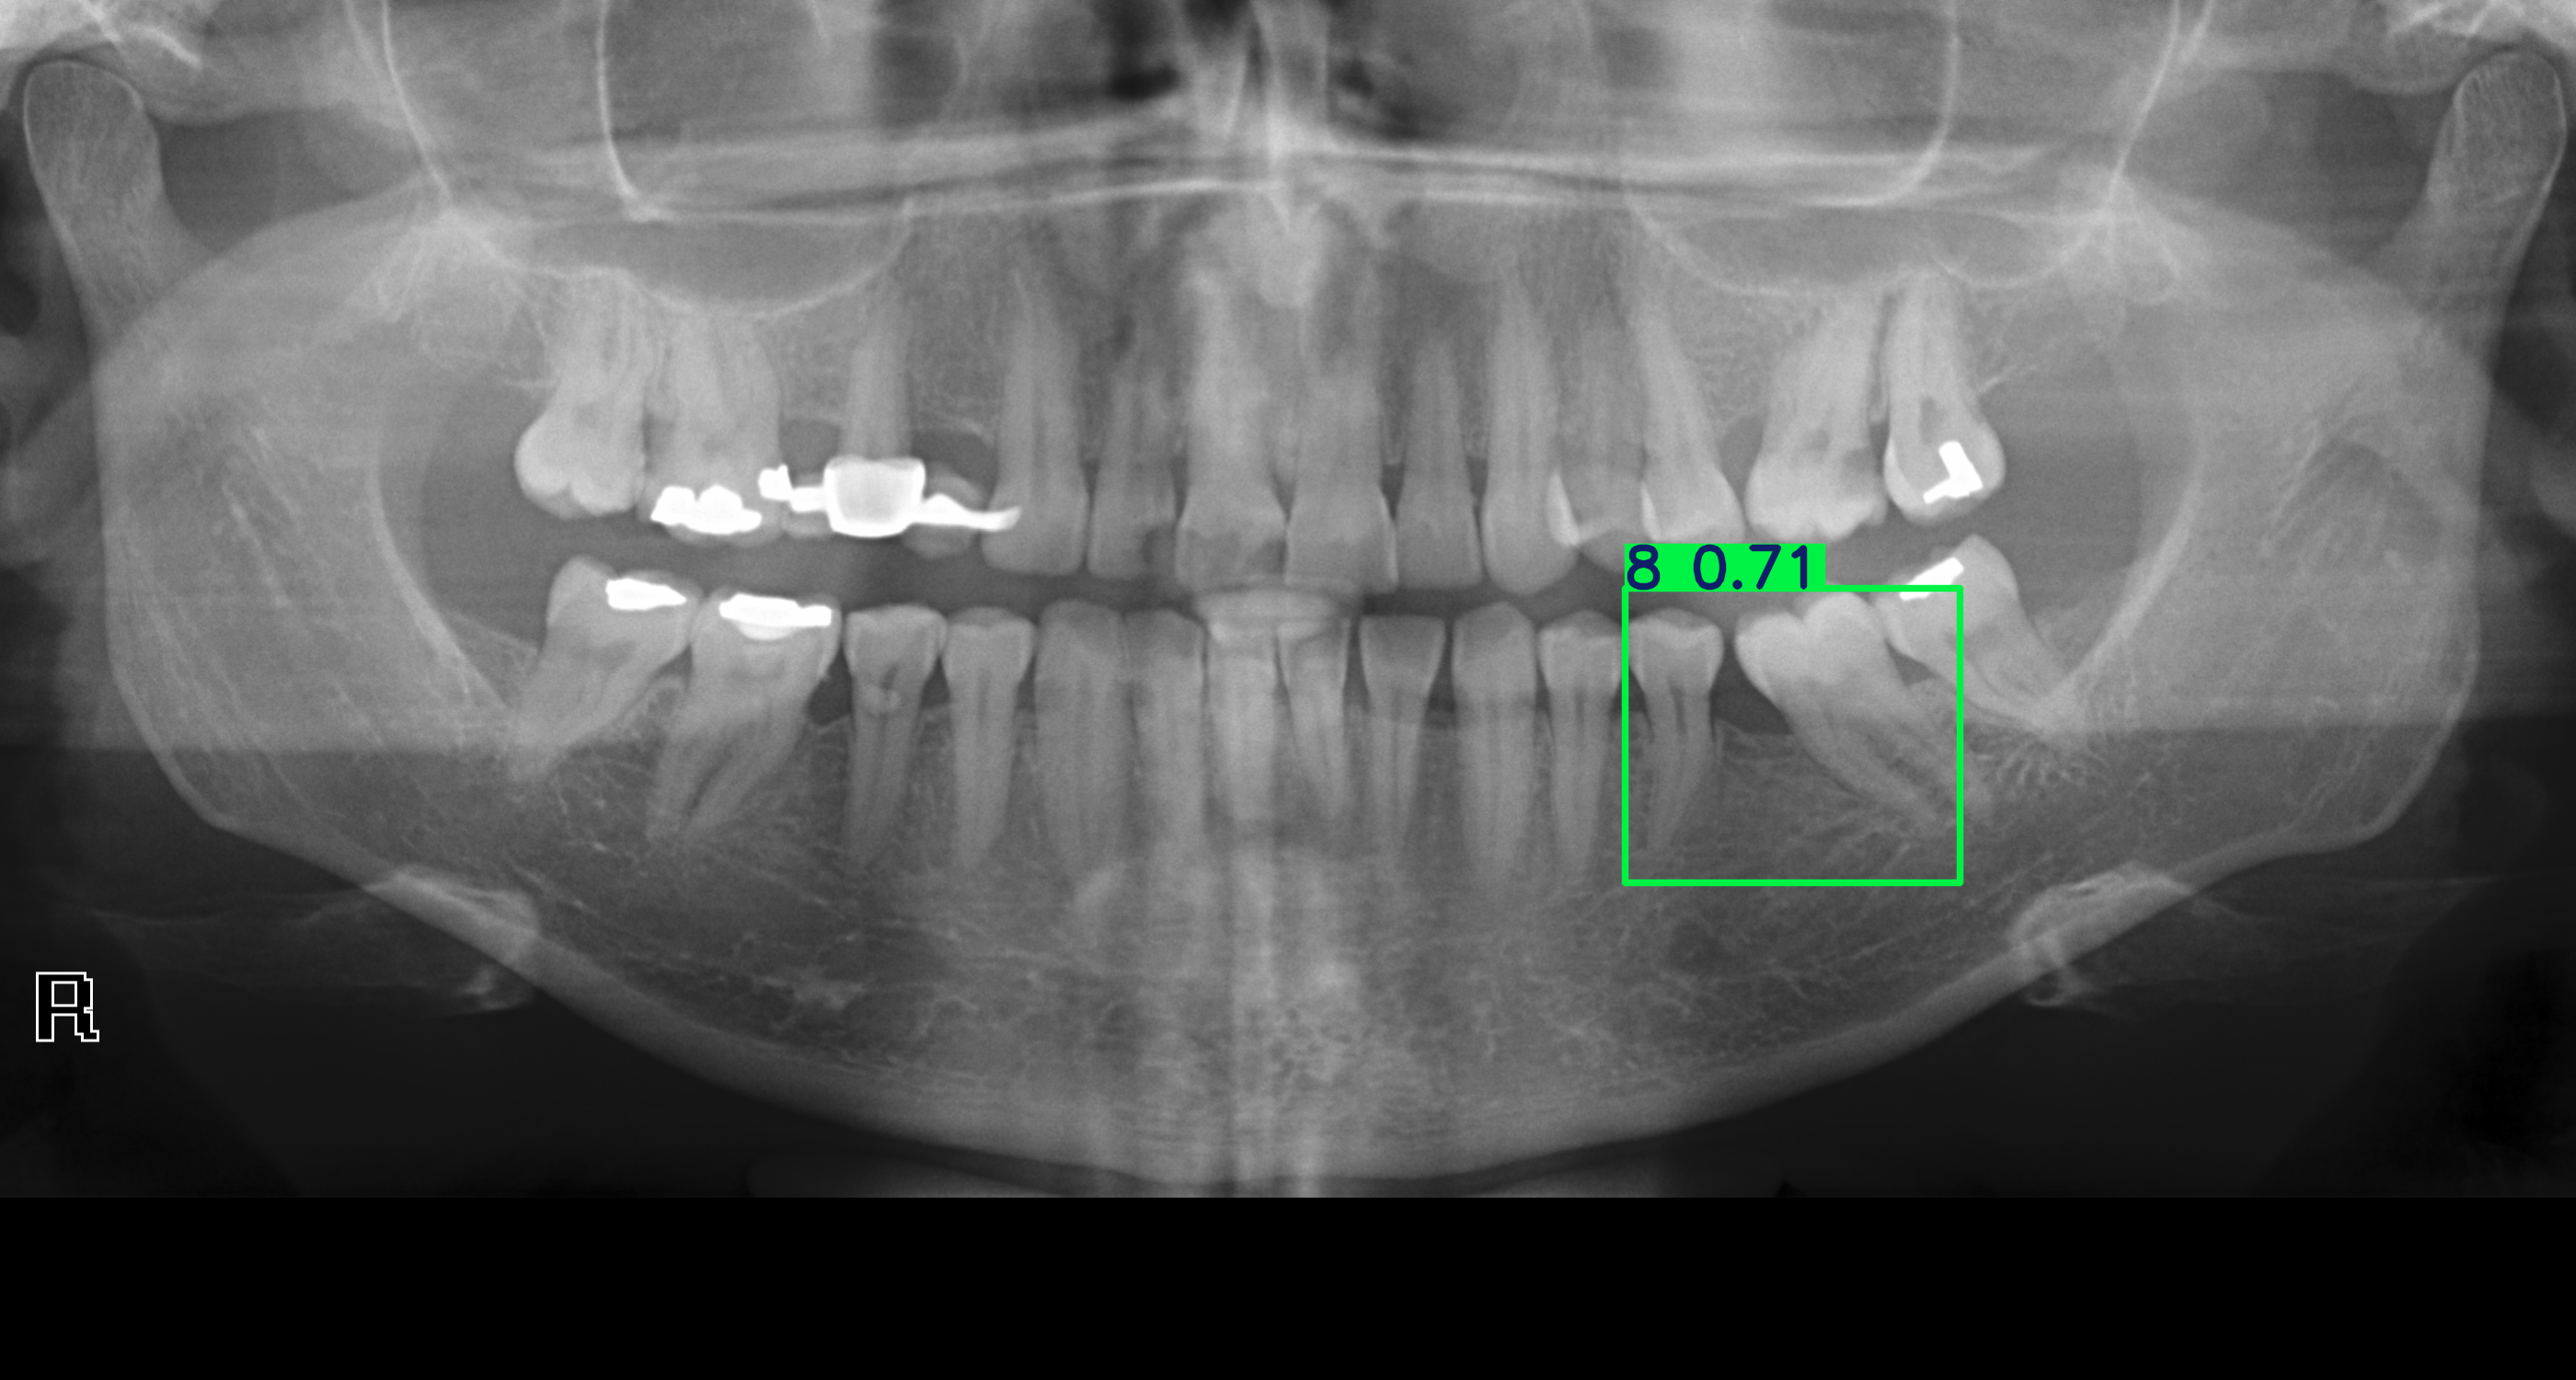


--- End of Script ---


In [17]:
folder_name_single = 'valid' # Ensure this matches the listing cell: 'train', 'valid', or 'test'
img_idx = 23    # <<< SET THE INDEX (number) of the image you want to test (1-based)
# ----------------------------------------------

# Proceed only if training was successful and image files were listed
if model_path and files_in_folder and 'model_predict' in locals() and model_predict:
    print(f"\n--- Running Single Image Inference ---")
    selected_folder_single=f'{dest_folder}/{folder_name_single}'
    image_folder_single = f'{selected_folder_single}/images'
    label_folder_single = f'{selected_folder_single}/labels'

    if not 1 <= img_idx <= len(files_in_folder):
        print(f"ERROR: Image index {img_idx} is out of bounds (1 to {len(files_in_folder)}).")
        print("Skipping single image inference.")
    else:
        img_filename_to_test = files_in_folder[img_idx-1]
        print(f"Selected image file: {img_filename_to_test}")

        image_path_to_test = f'{image_folder_single}/{img_filename_to_test}'
        label_path_to_test = f'{label_folder_single}/{os.path.splitext(img_filename_to_test)[0]}.txt'

        if not os.path.exists(image_path_to_test):
             print(f"ERROR: Selected image file not found at {image_path_to_test}")
        else:
            # Make prediction using the loaded best/last model
            try:
                predicted_single = model_predict.predict(source=image_path_to_test,
                                                  imgsz=image_size,
                                                  conf=0.25, # Use a confidence threshold
                                                  verbose=False)
                all_detected_classes_single=[]

                print(f'\nImage title: {img_filename_to_test}' )

                # --- Predicted Results ---
                print('\nPredicted Results:')
                if not predicted_single or not predicted_single[0] or not hasattr(predicted_single[0], 'boxes'):
                    objects_predicted_single = 0
                    print('Total objects detected: 0 (Prediction failed or empty result)')
                else:
                    objects_predicted_single=len(predicted_single[0].boxes)
                    print('Total objects detected:',objects_predicted_single)
                    print('Class   Class name             BBox (xywh_norm)         Confidence')
                    print('-----   --------------------   -----------------------  ----------')
                    if objects_predicted_single > 0:
                        for i in range(objects_predicted_single):
                          try:
                            label = int(predicted_single[0].boxes.cls[i].item())
                            conf = predicted_single[0].boxes.conf[i].item()
                            box_coords = predicted_single[0].boxes.xywhn[i].tolist()
                            all_detected_classes_single.append(f'{class_name[label]}')
                            print(f'{label: <5}   {class_name[label]:<20}   '
                                  f'{box_coords[0]:.3f},{box_coords[1]:.3f},{box_coords[2]:.3f},{box_coords[3]:.3f}   '
                                  f'{conf:.3f}')
                          except Exception as e:
                            print(f"Error processing prediction {i}: {e}")
                    else:
                        print("(No objects detected above confidence threshold)")

                # --- Diagnosis ---
                results_single=diagnosis(all_detected_classes_single)
                print('\nDiagnosis:')
                [print(f'- {diag_item}') for diag_item in results_single]

                # --- Ground Truth ---
                print('\nGround Truth:')
                if os.path.exists(label_path_to_test):
                    with open(label_path_to_test) as f:
                      print('Class   Class name             BBox (xywh_norm)')
                      print('-----   --------------------   -----------------------')
                      gt_count_single = 0
                      for line in f:
                        try:
                            parts=line.strip().split()
                            if len(parts) == 5:
                                gt_label = int(parts[0])
                                gt_x = float(parts[1])
                                gt_y = float(parts[2])
                                gt_w = float(parts[3])
                                gt_h = float(parts[4])
                                print(f'{gt_label: <5}   {class_name[gt_label]:<20}   '
                                      f'{gt_x:.3f},{gt_y:.3f},{gt_w:.3f},{gt_h:.3f}')
                                gt_count_single += 1
                            else:
                                print(f'Skipping malformed GT line: {line.strip()}')
                        except Exception as e:
                            print(f"Error parsing GT line: {line.strip()} - {e}")
                      if gt_count_single == 0:
                          print("(No ground truth objects in label file)")
                else:
                    print(f'(Label file not found: {label_path_to_test})')

                # --- Display Image with Predictions ---
                print("\nDisplaying image with predicted bounding boxes:")
                try:
                    # Plotting the results - uses BGR format expected by cv2
                    img_ann_bgr = predicted_single[0].plot()
                    # Convert BGR to RGB for PIL/display
                    img_ann_rgb = cv2.cvtColor(img_ann_bgr, cv2.COLOR_BGR2RGB)
                    img_ann = Image.fromarray(img_ann_rgb)
                    display(img_ann) # Use IPython display for Colab
                except Exception as e:
                    print(f"Error displaying annotated image: {e}")

            except Exception as e:
                 print(f"ERROR during single image prediction or processing: {e}")

elif not model_path:
    print("\n--- Skipping Single Image Inference ---")
    print("Reason: Training did not complete successfully or model path is not defined.")
elif not files_in_folder:
     print("\n--- Skipping Single Image Inference ---")
     print("Reason: No image files were found to select from.")
else:
     print("\n--- Skipping Single Image Inference ---")
     print("Reason: Model was not loaded successfully for prediction ('model_predict' not defined).")


print("\n--- End of Script ---")